In [1]:
from pychastic.sde_solver import SDESolver
from pychastic.sde_solver import VectorSDESolver
import pychastic
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm


# Testing Vector Euler

In [121]:
problem = pychastic.sde_problem.VectorSDEProblem(
  lambda x: jnp.array([1/(2*x[0]),0]),       # [1/2r,0]
  lambda x: jnp.array([
    [jnp.cos(x[1]),jnp.sin(x[1])],           # cos \phi,      sin \phi
    [-jnp.sin(x[1])/x[0],jnp.cos(x[1])/x[0]] # -sin \phi / r, cos \phi / r
  ]),
  dimension = 2,
  noiseterms= 2,
  x0 = jnp.array([1.0,0.0]), # r=1.0, \phi=0.0
  tmax=1.0
)


solvers = [
  pychastic.sde_solver.VectorSDESolver(scheme='euler'),
  #SDESolver(adaptive=False, scheme='milstein'),
]

dts = [2**-4, 2**-5, 2**-6, 2**-7]
n_rows = 10
n_wieners_per_cell = 100

results = np.zeros((len(solvers), len(dts), n_rows, n_wieners_per_cell), dtype=dict)  # solver x dt x wiener

for n_solver, solver in enumerate(solvers):
  for n_dt, dt in tqdm(enumerate(dts)):
    solver.dt = dt
    #for n_row in tqdm(range(n_rows)):
    for n_row in range(n_rows):
      solutions = solver.solve_many(problem,n_trajectories=n_wieners_per_cell)
      #solutions = np.array([solver.solve(problem) for it in range(n_wieners_per_cell)])
      results[n_solver, n_dt, n_row] = solutions

100%|██████████| 100/100 [00:00<00:00, 162.86it/s]

100%|██████████| 100/100 [00:01<00:00, 63.48it/s]
4it [00:49, 12.47s/it]


In [176]:
s = results.shape
results_flat = results.flatten()
def to_cartesian(x):
  return x[0]*jnp.array([jnp.cos(x[1]),jnp.sin(x[1])])
def f(sol):
  x = to_cartesian(sol['solution_values'][-1])
  x_exact = sol['wiener_values'][-1] + jnp.array([1,0])
  e = jnp.sqrt(jnp.sum((x - x_exact)**2)) # L2 norm error
  return e
errors = np.array([f(x) for x in results_flat]).reshape(s)
errors.shape

(1, 4, 10, 100)

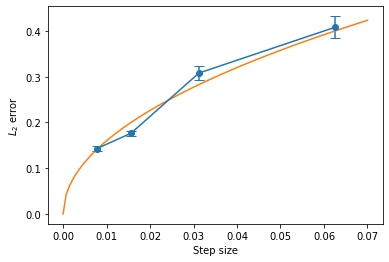

In [190]:
table_euler = errors[0].mean(axis=-1).T
mu_euler = table_euler.mean(axis=0)
sd_euler = table_euler.std(axis=0)/np.sqrt(n_wieners_per_cell)
mu_pred = [1.6*x**(1/2) for x in jnp.linspace(0.0,0.07,100)]
plt.errorbar(dts, mu_euler, 2*sd_euler, capsize=5, marker='o')
plt.xlabel('Step size')
plt.ylabel('$L_2$ error')
plt.plot(jnp.linspace(0,0.07,100), mu_pred)